This notebook tests how to iterate throught all sample data tokens, get annotation, and so on.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from skimage.io import imread
import numpy as np

from prepare_lyft_data import extract_single_box, \
    parse_train_csv, level5data, extract_boxed_clouds, \
    get_sample_images, get_train_data_sample_token_and_box, \
    get_pc_in_image_fov, transform_bounding_box_to_sensor_coord_and_get_corners, \
    get_2d_corners_from_projected_box_coordinates, transform_image_to_world_coordinate,\
transform_world_to_image_coordinate,extract_other_sensor_token,\
transform_box_from_world_to_sensor_coordinates,get_box_yaw_angle_in_world_coords,get_sensor_to_world_transform_matrix
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud,Quaternion,Box
from lyft_dataset_sdk.utils.geometry_utils import points_in_box,transform_matrix
from parse_pointnet_output import rotate_pc_along_y,get_heading_angle,get_size,get_center_in_sensor_coord

/Users/kanhua/miniconda3/envs/lyft-3d/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/kanhua/miniconda3/envs/lyft-3d/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/kanhua/miniconda3/envs/lyft-3d/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/kanhua/miniconda3/envs/lyft-3d

In [3]:
level5data.scene[0]

{'log_token': 'da4ed9e02f64c544f4f1f10c6738216dcb0e6b0d50952e158e5589854af9f100',
 'first_sample_token': '24b0962e44420e6322de3f25d9e4e5cc3c7a348ec00bfa69db21517e4ca92cc8',
 'name': 'host-a101-lidar0-1241893239199111666-1241893264098084346',
 'description': '',
 'last_sample_token': '2346756c83f6ae8c4d1adec62b4d0d31b62116d2e1819e96e9512667d15e7cec',
 'nbr_samples': 126,
 'token': 'da4ed9e02f64c544f4f1f10c6738216dcb0e6b0d50952e158e5589854af9f100'}

iterate through the sample tokens

In [4]:
start_sample_token=level5data.scene[0]['first_sample_token']

In [19]:
scene_num=len(level5data.scene)
print("number of scenes:",scene_num)

number of scenes: 180


In [5]:
sample_data_token=level5data.get('sample',start_sample_token)['data']['CAM_FRONT']

In [6]:
level5data.get('sample_data',sample_data_token)

{'width': 1920,
 'height': 1080,
 'calibrated_sensor_token': '8e73e320d1fa9e5af96059e6eb1dd7d28e3271dea04de86ead47fa25fd13fd20',
 'token': 'fb40b3b5b9d289cd0e763bec34e327d3317a7b416f787feac0d387363b4d00f0',
 'sample_token': '24b0962e44420e6322de3f25d9e4e5cc3c7a348ec00bfa69db21517e4ca92cc8',
 'is_key_frame': True,
 'prev': '',
 'fileformat': 'jpeg',
 'ego_pose_token': '0c257254dad346c9d90f7970ce2c0b8142f7c6e6a90716f4c0538cd2d2ef77d5',
 'timestamp': 1557858039250000.0,
 'next': '00ba71deb97524b5d9be9b677962b74bb32f89284ad7838462250218786b903e',
 'filename': 'images/host-a101_cam0_1241893239250000006.jpeg',
 'sensor_modality': 'camera',
 'channel': 'CAM_FRONT'}

In [7]:
test_anns_token=level5data.get('sample',start_sample_token)['anns'][10]
level5data.get('sample_annotation',test_anns_token)

{'token': '64e6ea3476f64420c76db21b2fa4ec589def2c05ad97d2574ea63f8f0f7f22c9',
 'num_lidar_pts': -1,
 'size': [1.926, 4.468, 1.646],
 'sample_token': '24b0962e44420e6322de3f25d9e4e5cc3c7a348ec00bfa69db21517e4ca92cc8',
 'rotation': [0.1495153129778906, 0, 0, 0.9887594101626156],
 'prev': '',
 'translation': [1015.7797918115841, 1698.112905723589, -23.365489708743098],
 'num_radar_pts': 0,
 'attribute_tokens': ['1ba8c9a8bda54423fa710b0af1441d849ecca8ed7b7f9393ba1794afe4aa6aa2',
  'daf16a3f6499553cc5e1df4a456de5ee46e2e6b06544686d918dfb1ddb088f6f'],
 'next': 'a43b9692c479c7d858042f3c887a8495a9557c830387c98194780101c17ca581',
 'instance_token': 'a346a47516af3ead5f95f18972b0b8289715597ea7c50e3f579170a6d5b365fe',
 'visibility_token': '',
 'category_name': 'car'}

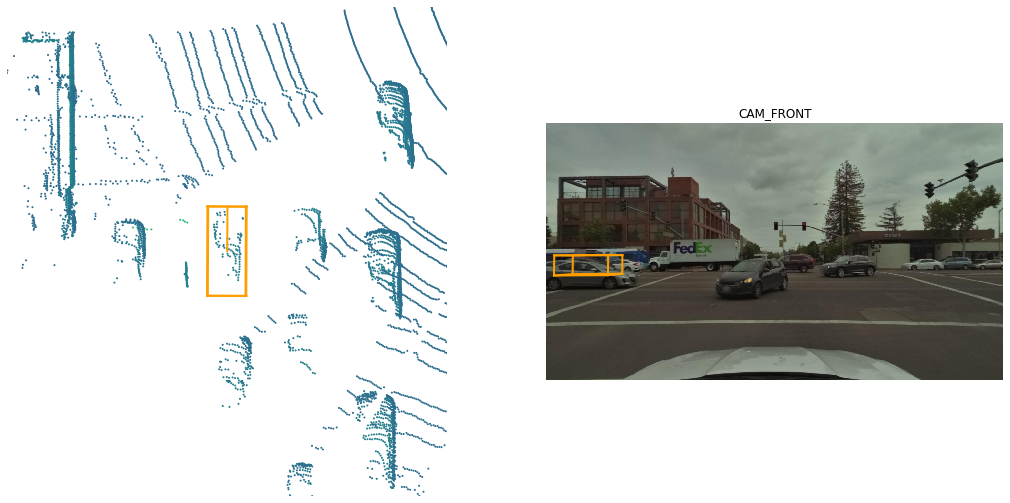

In [8]:
#fig,ax=plt.subplots()
level5data.render_annotation(test_anns_token)

In [9]:
sample_token=start_sample_token
while sample_token != "":
    print(sample_token)
    sample_record=level5data.get('sample',sample_token)
    
    next_sample_token=sample_record['next']
    sample_token=next_sample_token

24b0962e44420e6322de3f25d9e4e5cc3c7a348ec00bfa69db21517e4ca92cc8
c2ba18e4414ce9038ad52efab44e1a0a211ff1e6b297a632805000510756174d
57c823209ea714288c2f56a3bf2510a9f02db43310ee3631a7d678b191645e12
29fd7d429450b8ac7478323ef9d5eede87fd184d74c3c36cd2e2853281043459
282b5aec05ed14275e0a7fb3f785c4cb4ad096a0faee0c5bf1d42122c646d194
77b06d3bf949065494854130baf017b26bad5644e32a22a47d2b0fea4b2e6202
f07f93ccbfea34a7d3918672746551589326c04c82ff09be5dafa3d8758c17b3
49852b89c18e528939a1a5545906854309ba702b64ced64adfb1a82ef4437d82
26796129628aa4816ba6bf2e71a43b77779d4d5bb33c194c0930a522207fff08
a218dcf0d22b4b8dfdf5e8fdca59b1dbb657458ff4b01d689d8dc05476d391e6
fc4c6de4978b8f568839e7f9b1f107085f6d87153817257acd58b70db096f8ae
6c67092c8464af4f86e5927e8abda9a3ef6cb5b00222901d3dc25d9df2906abb
cb9fe9729501c10721fee939bf2bd42f2c8e8952fec532bb40cb83f09a09c3ed
756b3345ba8714dc6f48ed973fd1364b760075741e37c347c25c9fca8891e5a5
e1c4cd624b36f95bd14915f5b0526dbb8554e878aa7b9eb294de76bd4730f90a
97285bf4a7d24c9d554f8ef7b

In [10]:
from lyft_dataset_sdk.utils.geometry_utils import box_in_image,BoxVisibility

In [11]:
def select_annotation_boxes(sample_token,box_vis_level:BoxVisibility=BoxVisibility.ALL,camera_type=['CAM_FRONT']):
    sample_record=level5data.get('sample',sample_token)
    
    cams = [key for key in sample_record["data"].keys() if "CAM" in key]
    cams = [cam for cam in cams if cam in camera_type]
    for ann_token in sample_record['anns']: 
        for cam in cams:
            cam_token=sample_record["data"][cam]
            _, boxes, cam_intrinsic = level5data.get_sample_data(
                cam_token, box_vis_level=box_vis_level, selected_anntokens=[ann_token]
            )
            if len(boxes)>0:
                yield sample_token,cam_token,boxes[0]

In [12]:
for tks in select_annotation_boxes(start_sample_token):
    print(tks)

('24b0962e44420e6322de3f25d9e4e5cc3c7a348ec00bfa69db21517e4ca92cc8', 'fb40b3b5b9d289cd0e763bec34e327d3317a7b416f787feac0d387363b4d00f0', label: nan, score: nan, xyz: [5.58, 1.13, 20.87], wlh: [1.95, 4.67, 1.74], rot axis: [0.15, 0.69, -0.71], ang(degrees): 163.60, ang(rad): 2.86, vel: nan, nan, nan, name: car, token: 3d7bdcb0c99a5ba50cc74b9b9194fe4f2fdfa82a078c8afa561eec9afad052f9)
('24b0962e44420e6322de3f25d9e4e5cc3c7a348ec00bfa69db21517e4ca92cc8', 'fb40b3b5b9d289cd0e763bec34e327d3317a7b416f787feac0d387363b4d00f0', label: nan, score: nan, xyz: [-15.70, 1.16, 22.42], wlh: [1.93, 4.47, 1.65], rot axis: [1.00, 0.01, -0.02], ang(degrees): 88.51, ang(rad): 1.54, vel: nan, nan, nan, name: car, token: 64e6ea3476f64420c76db21b2fa4ec589def2c05ad97d2574ea63f8f0f7f22c9)
('24b0962e44420e6322de3f25d9e4e5cc3c7a348ec00bfa69db21517e4ca92cc8', 'fb40b3b5b9d289cd0e763bec34e327d3317a7b416f787feac0d387363b4d00f0', label: nan, score: nan, xyz: [17.99, 1.57, 33.51], wlh: [1.76, 5.19, 1.45], rot axis: [0.00,

In [13]:
results=list(select_annotation_boxes(start_sample_token))


In [14]:
results[0][2]

label: nan, score: nan, xyz: [5.58, 1.13, 20.87], wlh: [1.95, 4.67, 1.74], rot axis: [0.15, 0.69, -0.71], ang(degrees): 163.60, ang(rad): 2.86, vel: nan, nan, nan, name: car, token: 3d7bdcb0c99a5ba50cc74b9b9194fe4f2fdfa82a078c8afa561eec9afad052f9

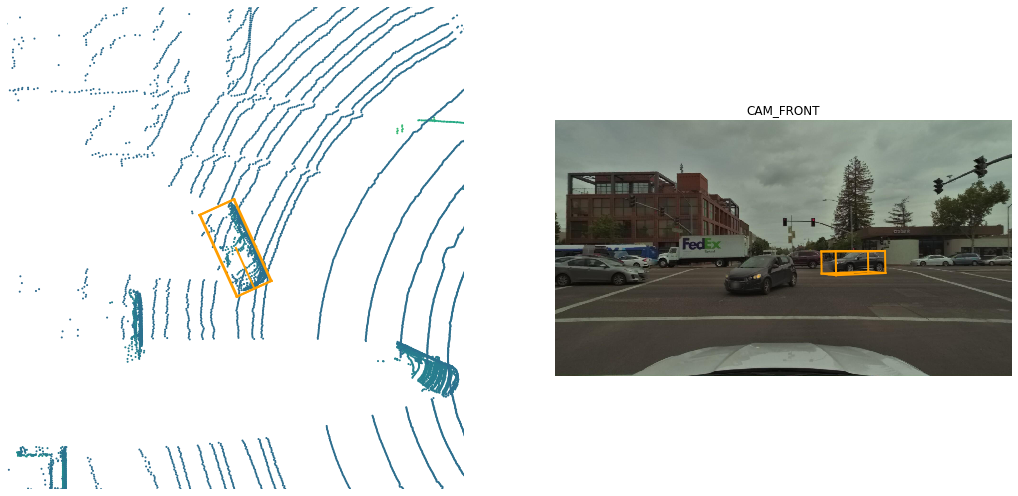

In [15]:
level5data.render_annotation(results[0][2].token,box_vis_level=BoxVisibility.ALL)

In [16]:
def get_all_boxes_in_single_scene(scene_number):
    results=[]
    start_sample_token=level5data.scene[0]['first_sample_token']
    sample_token=start_sample_token
    while sample_token != "":
        sample_record=level5data.get('sample',sample_token)
        for tks in select_annotation_boxes(sample_token):
            results.append(tks)
        
        next_sample_token=sample_record['next']
        sample_token=next_sample_token
    
    return results

In [17]:
get_all_boxes_in_single_scene(0)

[('24b0962e44420e6322de3f25d9e4e5cc3c7a348ec00bfa69db21517e4ca92cc8',
  'fb40b3b5b9d289cd0e763bec34e327d3317a7b416f787feac0d387363b4d00f0',
  label: nan, score: nan, xyz: [5.58, 1.13, 20.87], wlh: [1.95, 4.67, 1.74], rot axis: [0.15, 0.69, -0.71], ang(degrees): 163.60, ang(rad): 2.86, vel: nan, nan, nan, name: car, token: 3d7bdcb0c99a5ba50cc74b9b9194fe4f2fdfa82a078c8afa561eec9afad052f9),
 ('24b0962e44420e6322de3f25d9e4e5cc3c7a348ec00bfa69db21517e4ca92cc8',
  'fb40b3b5b9d289cd0e763bec34e327d3317a7b416f787feac0d387363b4d00f0',
  label: nan, score: nan, xyz: [-15.70, 1.16, 22.42], wlh: [1.93, 4.47, 1.65], rot axis: [1.00, 0.01, -0.02], ang(degrees): 88.51, ang(rad): 1.54, vel: nan, nan, nan, name: car, token: 64e6ea3476f64420c76db21b2fa4ec589def2c05ad97d2574ea63f8f0f7f22c9),
 ('24b0962e44420e6322de3f25d9e4e5cc3c7a348ec00bfa69db21517e4ca92cc8',
  'fb40b3b5b9d289cd0e763bec34e327d3317a7b416f787feac0d387363b4d00f0',
  label: nan, score: nan, xyz: [17.99, 1.57, 33.51], wlh: [1.76, 5.19, 1.45],